# Computing the Value of Information for supporting system design

Probably investigate reducing uncertainty in mean load as that is nice and simple - first perfect information, then imperfect information

In [ ]:
from tqdm.auto import tqdm
import numpy as np
from numpy import random
from scipy import stats

from models import sample_posterior
from models import run_model
from functools import partial
from utils import get_Gurobi_WLS_env, fmt_design_results

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
env = get_Gurobi_WLS_env(silence=True)
run_model = partial(run_model, env=env)

In [4]:
solar_years = range(2012,2018)
load_years = range(2012,2018)

load_mean = 100
load_std = 10
reduction_factor = 0.33

In [5]:
def sample_load_prior(nsamples):
    thetas = stats.truncnorm.rvs(-2, 2, loc=load_mean, scale=load_std, size=nsamples)
    zs = stats.norm.rvs(loc=thetas, scale=load_std*reduction_factor)
    return thetas, zs

def build_scenarios(load_samples):

    n = len(load_samples)

    scenarios = {
        'solar_year': random.choice(solar_years, n),
        'load_year': random.choice(load_years, n),
        'mean_load': load_samples,
        'battery_efficiency': stats.truncnorm.rvs(-2, 2, loc=0.9, scale=0.05, size=n)
    }

    return scenarios

Prior

In [11]:
tsamples = 10
thetas, zs = sample_load_prior(tsamples)
print(thetas)
print(zs)

[111.77272993  96.58825587  84.34983037 103.85380366 108.39588375
  95.48586356 110.30692539  95.46281804  97.447831   110.8470759 ]
[114.01968505  93.9340661   83.99433892 103.31605844 107.41866854
  95.67889485 109.44720922  93.51540003 101.77913538 107.81268629]


In [6]:
scenarios = build_scenarios(thetas)

prior_results = run_model(
    solar_capacity=None,
    battery_capacity=None,
    **scenarios
)

print(fmt_design_results(prior_results))

Parameter         Unit      Value
----------------  ------  -------
Solar capacity    kWp       849.1
Battery capacity  kWh       430.4
Total cost        £k/yr     168.8
CAPEX             £k/yr     106.4
OPEX              £k/yr      62.3


Could do VoI with discrete design options (i.e. not On-Policy VoI), but is it that informative? Is it worth it?

In [1]:
...

Ellipsis

Perfect information - ToDo

In [7]:
...

Ellipsis

*Should I take the other uncertainties out for the initial calcs to make the EVPI computations simpler? I.e. not need an expectation per z (actual perfect information, not partial perfect information). Then I could add them back in for the EVII calcs*

Imperfect information

In [16]:
vsamples = 10
samples = sample_posterior(z=zs[0], nsamples=vsamples, reduction_factor=reduction_factor)
print(samples)

[110.03  114.066 111.66  113.999 112.931 111.128 112.721 114.512 111.207
 113.96 ]


Text(0, 0.5, '')

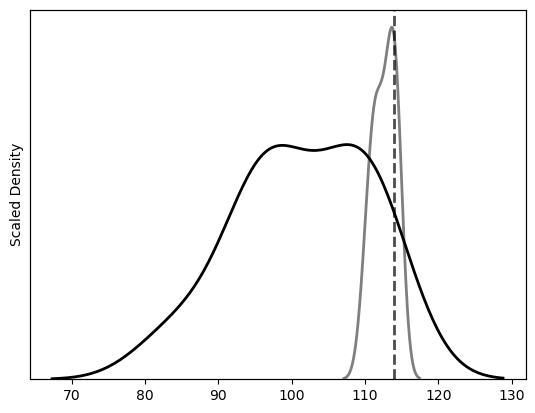

In [26]:
fig, ax = plt.subplots()

sns.kdeplot(thetas,label='prior',color='k',lw=2)

ymax = ax.get_ylim()[1]*1.5
plt.vlines(zs[0],0,ymax,label='Measurement',color='k', alpha=0.7, ls='--', lw=2)

ax2 = ax.twinx()
sns.kdeplot(
    samples,
    #cut=0,
    label='posterior',
    ax=ax2, c='k', alpha=0.5, lw=2
)

ax.set_ylim(0,ymax)
ax.get_yaxis().set_ticks([])
ax.yaxis.set_label_text('Scaled Density')
ax2.get_yaxis().set_ticks([])
ax2.yaxis.set_label_text('')

In [10]:
results = []

for theta,z in tqdm(zip(thetas, zs), total=tsamples):

    varthetas = sample_posterior(z=z, nsamples=vsamples, reduction_factor=reduction_factor)

    scenarios = build_scenarios(varthetas)

    post_results = run_model(
        solar_capacity=None,
        battery_capacity=None,
        **scenarios
    )

    results.append(post_results)

100%|██████████| 10/10 [01:24<00:00,  8.44s/it]


In [11]:
print(([r['total'] for r in results]))
print(np.mean([r['total'] for r in results]))

[175935.4109218436, 167495.09872357495, 174152.33637213838, 176887.14445522096, 177072.88280900038, 169626.52621284337, 170900.9289241613, 166212.70361441898, 153125.08803982736, 175004.54082281928]
170641.26608958485


In [12]:
prior_cost = prior_results['total']
posterior_cost = np.mean([r['total'] for r in results])
print(f'Prior cost: {prior_cost}')
print(f'Posterior cost: {posterior_cost}')
print(f'VoI: {prior_cost - posterior_cost}')
voi_percent = (prior_cost - posterior_cost) / prior_cost * 100
print(f'VoI percent: {voi_percent:.2f}%')

Prior cost: 168773.4040373979
Posterior cost: 170641.26608958485
VoI: -1867.8620521869452
VoI percent: -1.11%
